# Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from operator import itemgetter

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


# Create a test network of 11 nodes

In [22]:
# Test network used to run the file without the SDN Mininet simulation
switch_list_weighted = [(9, 8, 600), (9, 11, 320), (9, 10, 730), 
              (9, 7, 565), (9, 6, 350), (8, 2, 450), 
              (8, 11, 820), (8, 5, 300), (8, 6, 400), 
              (8, 4, 1090), (3, 1, 760), (3, 6, 390), (3, 5, 210), 
              (3, 4, 660), (3, 2, 550), (2, 1, 1310), (2, 5, 390), 
              (1, 7, 740), (1, 4, 390), (7, 10, 320), (7, 6, 730), 
              (7, 4, 340), (6, 5, 220), (5, 11, 930), (4, 10, 660), 
              (11, 10, 820)]

In [23]:
# Make topology by seperating out the weights from the switches
switch_list_weighted_minus1 = []
for i in switch_list_weighted:   
    pair = ()
    for j in i:
        # If j > 100 its a weight and should not be reduced by 1.
        if (j < 100):        
            pair = pair + (j - 1,)
        else:
            pair = pair + (j,)
    switch_list_weighted_minus1.append(pair)
       
switch_list_unweighted = [x[:-1] for x in switch_list_weighted_minus1] 

weights_dict = {(a,b):c for a,b,c in switch_list_weighted_minus1}

In [24]:
#Finds the largest node to calculate size of matrix
max1 = max(switch_list_unweighted, key = itemgetter(0))[0] 
max2 = max(switch_list_unweighted, key = itemgetter(1))[1] 
largest_state = max(max1, max2)

In [25]:
initial_state = 0

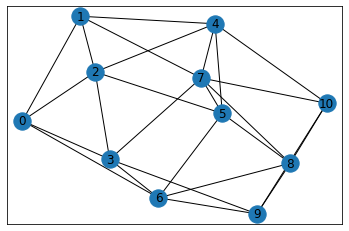

In [58]:
#Create networkx graphs with weights
G=nx.Graph()
G.add_edges_from(switch_list_unweighted)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.savefig("/Users/francesco/network.png", transparent=True, dpi=300)
plt.show()

# Make the Q-Matrix

In [27]:
# Highest numbered switch + 1 (as we start from switch 0)
MATRIX_SIZE = largest_state + 1

# Create matrix x*y
R_weight = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R_weight *= -1

In [28]:
# Assign zeros to paths and 100 to final_state-reaching point
for point in switch_list_unweighted:
    if point[1] == largest_state:
        R_weight[point] = 100
    else:
        R_weight[point] = 0

    if point[0] == largest_state:
        R_weight[point[::-1]] = 100
    else:
        R_weight[point[::-1]]= 0

In [29]:
# Add final_state point round trip
R_weight[largest_state, largest_state]= 100

Q_weight = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# Normalised weights between 0 and 1
maxWeight = max(v for k, v in weights_dict.items() if v != 0)
minWeight = min(v for k, v in weights_dict.items() if v != 0)

In [30]:
# Makes the weighted matrix. 
for switch, weight in weights_dict.items():
    Q_weight[switch[0], switch[1]] = 1-(weight-minWeight)/(maxWeight-minWeight)
    Q_weight[switch[1], switch[0]] = 1-(weight-minWeight)/(maxWeight-minWeight)
    
Q_weight[largest_state, largest_state]= 1

R = np.add(R_weight, Q_weight)

In [31]:
np.set_printoptions(precision=1) #Formatting
print(R)

[[ -1.    0.    0.5   0.8  -1.   -1.    0.5  -1.   -1.   -1.   -1. ]
 [  0.   -1.    0.7  -1.    0.8  -1.   -1.    0.8  -1.   -1.   -1. ]
 [  0.5   0.7  -1.    0.6   1.    0.8  -1.   -1.   -1.   -1.   -1. ]
 [  0.8  -1.    0.6  -1.   -1.   -1.    0.9   0.2  -1.    0.6  -1. ]
 [ -1.    0.8   1.   -1.   -1.    1.   -1.    0.9  -1.   -1.  100.3]
 [ -1.   -1.    0.8  -1.    1.   -1.    0.5   0.8   0.9  -1.   -1. ]
 [  0.5  -1.   -1.    0.9  -1.    0.5  -1.   -1.    0.7   0.9  -1. ]
 [ -1.    0.8  -1.    0.2   0.9   0.8  -1.   -1.    0.6  -1.  100.4]
 [ -1.   -1.   -1.   -1.   -1.    0.9   0.7   0.6  -1.    0.5 100.9]
 [ -1.   -1.   -1.    0.6  -1.   -1.    0.9  -1.    0.5  -1.  100.4]
 [ -1.   -1.   -1.   -1.    0.3  -1.   -1.    0.4   0.9   0.4 101. ]]


In [32]:
# Which actions can be taken?
def available_actions(state):
    current_state_row = R[state, ]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

In [33]:
#What should the next action be?
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_actions_range,1))
    return next_action

In [34]:
tf.reset_default_graph()

In [35]:
# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape = [1, MATRIX_SIZE], dtype = tf.float32)

# Store the possible actions to take
actions_placeholder = tf.placeholder(shape = [MATRIX_SIZE], dtype = tf.bool)
W = tf.Variable(tf.random_uniform([MATRIX_SIZE, MATRIX_SIZE], 0, 0.01)) #Outputs random values in uniform distibution shape [16,4]. Min value 0, max value 0.01
Qout = tf.matmul(inputs1, W) #Matrix multiplication
predict = tf.argmax(tf.boolean_mask(Qout, actions_placeholder, axis = 1), 1) #Max from the tensor? Returns where it is in the tensor [4]?


In [36]:
#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape = [1 ,MATRIX_SIZE], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout)) #Total loss value. Squared makes it +ve. e.g 6
trainer = tf.train.GradientDescentOptimizer(learning_rate = 0.1) #Optimizer
updateModel = trainer.minimize(loss)


In [37]:
init = tf.global_variables_initializer() 

# Run the Model

In [54]:
y = .99 #Gamma
e = 1 #epsilon
number_episodes = 20000

# Create lists to contain total rewards and steps per episode
stateList = [] 
rewardList = [] 
steps = []
maxRewardList = [0]

with tf.Session() as sess:
    sess.run(init)
    for i in range(number_episodes):

        rAll = 0 
        d = False
        current_state = 0
        j = 0 

        state_list = [0]
        while j < 99:

            j+=1
            possible_actions = available_actions(current_state)
            boolean_actions = [True if i in possible_actions else False for i in range(MATRIX_SIZE)]
            
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(MATRIX_SIZE)[current_state:current_state+1], 
                              actions_placeholder:boolean_actions}) 
            action = possible_actions[a[0]]
            
            # Random action                                                        
            if np.random.rand(1) < e:
                action = sample_next_action(possible_actions)
                
            #Get new state and reward from environment
            next_state = action
            reward = R[current_state, action]

            d = True if reward >= 100 else False

            
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(MATRIX_SIZE)[next_state:next_state+1]})
            
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)

            targetQ = allQ
            targetQ[0,action] = reward + y*maxQ1 
            
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(MATRIX_SIZE)[current_state:current_state+1],nextQ:targetQ})
            rAll -= reward 
            state_list.append(next_state)

            current_state = next_state
          
            if d == True:
                rAll += 2*reward
                #Reduce chance of random action as we train the model.
                if e > 0.1:
                    e = e - 1./((i/500) + 1000)
                else:
                    e = 0.1
                break
            
        rewardList.append(rAll)
stateList.append(state_list)

# Visualise the results

[0, 3, 6, 8, 10]


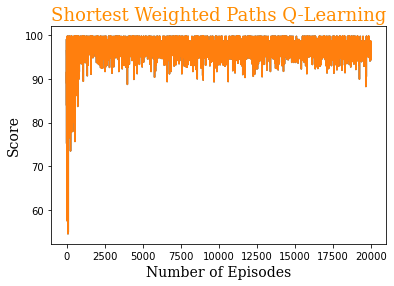

In [57]:
steps = stateList[0] 
print(steps)

plt.plot(rewardList)


fontTitle = {'family': 'serif',
        'color':  'darkorange',
        'weight': 'normal',
        'size': 18,
        }
fontText = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

plt.plot(rewardList)
plt.xlabel('Number of Episodes', fontdict = fontText)
plt.ylabel('Score', fontdict = fontText)
plt.title('Shortest Weighted Paths Q-Learning', fontdict = fontTitle)
plt.savefig("/Users/francesco/short_paths.png", transparent=True, dpi=300)
plt.show()
